In [1]:
import math
import random
import numpy as np
from plot_utils import draw_dot
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import os
np.random.seed(0)

In [2]:
LR = 0.01

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        # (self, ) is passed so that it behaves like a tuple
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

def get_value_array(shape):
    """
    A numpy array of shape `shape` randomly initialized between -1 and 1
    """
    if len(shape) == 1:
        return np.array([Value(random.uniform(-1.0, 1.0)) for _ in range(shape[0])])
    
    return np.array([get_value_array(shape[1:]) for _ in range(shape[0])])

def np_array_to_value_array(arr):
    """
    Convert a numpy array to a Value array
    """
    if len(arr.shape) == 1:
        return np.array([Value(v) for v in arr])
    
    return np.array([np_array_to_value_array(v) for v in arr])

def zero_grad_value_array(arr):
    """
    Set the gradient of all elements to 0
    """
    for v in arr.flatten():
        v.grad = 0.0
    
    return

def gradient_descent_value_array(arr, lr = LR):
    """
    Replace every `item` with `item - lr * item.grad`
    """
    for v in arr.flatten():
        v.data -= lr * v.grad

    return

class DenseLayer:
    def __init__(self, units, dim):
        self.W = get_value_array((units, dim))
        self.b = get_value_array((units, ))

        self.units = units
        self.dim = dim

    def forward(self, x):
        """
        Dimension of x should be (self.dim, ).
        Sigmoid activation is applied to the output.
        """
        assert x.shape == (self.dim, ), f"Shape should be ({self.dim}, ), got {x.shape}"

        Z = self.W @ x + self.b

        # Z.shape will be (self.units, )

        A = np.array([1.0/(1.0 + (-v).exp()) for v in Z])

        return A
    
    def zero_grad(self):
        zero_grad_value_array(self.W)
        zero_grad_value_array(self.b)

    def update(self, lr = LR):
        gradient_descent_value_array(self.W, lr = lr)
        gradient_descent_value_array(self.b, lr = lr)

    def num_parameters(self):
        return self.W.size + self.b.size

class Conv2D:
    def __init__(self, input_shape = (64, 64),
                 num_filters = 4,
                 kernel_size = 4,
                 strides = 2,
                 padding = 0):
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

        # Only for square images
        self.op_shape = (input_shape[0] + 2*padding - kernel_size) // strides + 1

        self.flattened_op_len = self.num_filters * (self.op_shape ** 2)

        # Kernel weights
        self.K = get_value_array((num_filters, kernel_size, kernel_size))

    def forward(self, x):
        """
        Dimension of x should be: `self.input_shape`.
        ReLU activation is applied to the output.
        """
        # Pad the input
        # print(x)
        # print(x.shape)
        x_pad = np.pad(x, ((self.padding, self.padding), (self.padding, self.padding)),
                   constant_values=Value(0.0))
        
        # Assigment operator is overloaded for Value
        res = get_value_array((self.num_filters, self.op_shape, self.op_shape))

        for f in range(self.num_filters):
            for i in range(self.op_shape):
                for j in range(self.op_shape):
                    i_start = i*self.strides
                    i_end = i_start + self.kernel_size
                    j_start = j*self.strides
                    j_end = j_start + self.kernel_size

                    temp_val = np.sum(x_pad[i_start: i_end, j_start: j_end] * self.K[f])

                    # Apply ReLU
                    res[f][i][j] = temp_val.relu()
        
        return res
    
    def zero_grad(self):
        zero_grad_value_array(self.K)

    def update(self, lr = LR):
        gradient_descent_value_array(self.K, lr = lr)

    def num_parameters(self):
        return self.K.size

In [3]:
def loss_fn(y_true, y_pred):
    """
    Mean Squared Error loss function
    """
    ls = (y_true - y_pred)**2
    # Return the value from the array
    # Squeeze the array
    return ls

In [4]:
class Model:
    def __init__(self, input_shape = (64, 64), kernel_size = 4, strides = 2, padding = 0, 
                 num_filters = 4, dense_units = 1):
        self.conv_1 = Conv2D(input_shape = input_shape, num_filters = num_filters,
                             kernel_size = kernel_size, strides = strides, padding = padding)
        
        self.dense_1 = DenseLayer(units = dense_units, dim = self.conv_1.flattened_op_len)

    def fit(self, X, y, num_epochs = 5,
            batch_size = 4,
            lr = LR):
        # Ceil of len(X) / batch_size
        steps_per_epoch = (X.shape[0] + batch_size - 1) // batch_size
        for ep in range(num_epochs):
            for stp in tqdm(range(steps_per_epoch), desc=f'Epoch {str(ep+1)}'):
                start_idx = stp * batch_size
                end_idx = min((stp+1) * batch_size, X.shape[0])

                X_batch = X[start_idx: end_idx]
                y_batch = y[start_idx: end_idx]

                losses = []

                for i in range(batch_size):
                    A = self.forward(X_batch[i])
                    # Calculate the loss
                    ls = loss_fn(y_batch[i], A[0])
                    losses.append(ls)

                comb_loss = sum(losses) / batch_size

                # Set all the gradients to 0
                self.zero_grad()

                # Backpropagate the loss
                comb_loss.backward()

                # Update the weights
                self.update(lr = lr)
            
            print(f'Epoch {ep+1}: Loss: {comb_loss.data}')

    
    def forward(self, x):
        """
        x should be of shape `self.input_shape`
        """
        conv_op = self.conv_1.forward(x)
        # Flatten the output
        flattened_op = conv_op.flatten()
        dense_op = self.dense_1.forward(flattened_op)
        return dense_op
    
    def zero_grad(self):
        self.conv_1.zero_grad()
        self.dense_1.zero_grad()

    def update(self, lr = LR):
        self.conv_1.update(lr = lr)
        self.dense_1.update(lr = lr)

    def predict(self, x):
        """
        `x` should be of shape `self.input_shape`
        """
        return self.forward(x)[0]
    
    def num_parameters(self):
        return self.conv_1.num_parameters() + self.dense_1.num_parameters()

## Prepare the data

In [5]:
CAT_DIR = '../data/PetImages/Cat/'
DOG_DIR = '../data/PetImages/Dog/'
NUM_IMAGES = 30
TRAIN_IMAGES = 20

In [6]:
# Choose 20 images from each category randomly
cat_images = np.random.choice(os.listdir(CAT_DIR), NUM_IMAGES)
dog_images = np.random.choice(os.listdir(DOG_DIR), NUM_IMAGES)

In [7]:
train_cat_images = cat_images[:TRAIN_IMAGES]
train_dog_images = dog_images[:TRAIN_IMAGES]
test_cat_images = cat_images[TRAIN_IMAGES:]
test_dog_images = dog_images[TRAIN_IMAGES:]

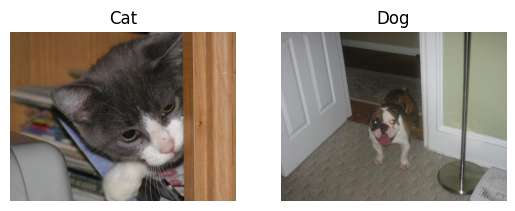

In [8]:
# Plot one cat image from train_cat_images and one dog image from train_dog_images
fig, axs = plt.subplots(1, 2)
cat_img = Image.open(CAT_DIR + train_cat_images[0])
dog_img = Image.open(DOG_DIR + train_dog_images[0])
axs[0].imshow(cat_img)
axs[0].set_title('Cat')
axs[0].axis('off')
axs[1].imshow(dog_img)
axs[1].set_title('Dog')
axs[1].axis('off')
plt.show()

### Cat: 0, Dog: 1

In [9]:
def get_data(dog_images, cat_images, resize_shape = (128, 128), shuffle = True):
    X = []
    y = []
    for dog_img in dog_images:
        img = Image.open(DOG_DIR + dog_img)
        img = img.resize(resize_shape)
        # Convert numbers to float and normalize them from 0 to 1
        img = np.array(img, dtype=np.float64) / 255.0
        # Take the average of the 3 color channels
        img = np.mean(img, axis=2)
        img_val_arr = np_array_to_value_array(img)
        X.append(img_val_arr)
        y.append(Value(1.0))
    for cat_img in cat_images:
        img = Image.open(CAT_DIR + cat_img)
        img = img.resize(resize_shape)
        # Convert numbers to float and normalize them from 0 to 1
        img = np.array(img, dtype=np.float64) / 255.0
        # Take the average of the 3 color channels
        img = np.mean(img, axis=2)
        img_val_arr = np_array_to_value_array(img)
        X.append(img_val_arr)
        y.append(Value(0.0))
    if shuffle:
        indices = np.random.permutation(len(X))
        X = [X[i] for i in indices]
        y = [y[i] for i in indices]
    return np.array(X), np.array(y)

In [10]:
resize_shape = (32, 32)
X_train, y_train = get_data(train_dog_images, train_cat_images, resize_shape = resize_shape)
X_test, y_test = get_data(test_dog_images, test_cat_images, resize_shape = resize_shape)

In [11]:
y_train

array([Value(data=1.0, grad=0), Value(data=1.0, grad=0),
       Value(data=0.0, grad=0), Value(data=0.0, grad=0),
       Value(data=1.0, grad=0), Value(data=0.0, grad=0),
       Value(data=0.0, grad=0), Value(data=1.0, grad=0),
       Value(data=1.0, grad=0), Value(data=1.0, grad=0),
       Value(data=0.0, grad=0), Value(data=0.0, grad=0),
       Value(data=0.0, grad=0), Value(data=1.0, grad=0),
       Value(data=0.0, grad=0), Value(data=1.0, grad=0),
       Value(data=0.0, grad=0), Value(data=0.0, grad=0),
       Value(data=0.0, grad=0), Value(data=0.0, grad=0),
       Value(data=1.0, grad=0), Value(data=0.0, grad=0),
       Value(data=0.0, grad=0), Value(data=0.0, grad=0),
       Value(data=1.0, grad=0), Value(data=0.0, grad=0),
       Value(data=1.0, grad=0), Value(data=0.0, grad=0),
       Value(data=1.0, grad=0), Value(data=1.0, grad=0),
       Value(data=1.0, grad=0), Value(data=0.0, grad=0),
       Value(data=1.0, grad=0), Value(data=1.0, grad=0),
       Value(data=0.0, grad=0),

In [12]:
print(X_train.shape, y_train.shape)
X_train[0][:5, :5]

(40, 32, 32) (40,)


array([[Value(data=0.5163398692810458, grad=0),
        Value(data=0.5137254901960785, grad=0),
        Value(data=0.5163398692810457, grad=0),
        Value(data=0.5372549019607843, grad=0),
        Value(data=0.538562091503268, grad=0)],
       [Value(data=0.5411764705882353, grad=0),
        Value(data=0.5411764705882353, grad=0),
        Value(data=0.5281045751633987, grad=0),
        Value(data=0.5281045751633987, grad=0),
        Value(data=0.5189542483660131, grad=0)],
       [Value(data=0.5542483660130718, grad=0),
        Value(data=0.5647058823529411, grad=0),
        Value(data=0.5555555555555555, grad=0),
        Value(data=0.5542483660130718, grad=0),
        Value(data=0.5516339869281045, grad=0)],
       [Value(data=0.5660130718954247, grad=0),
        Value(data=0.5490196078431372, grad=0),
        Value(data=0.538562091503268, grad=0),
        Value(data=0.5450980392156862, grad=0),
        Value(data=0.538562091503268, grad=0)],
       [Value(data=0.5555555555555555, 

In [13]:
# Plot one cat image from train_cat_images and one dog image from train_dog_images
# fig, axs = plt.subplots(1, 2)
# # Pick a cat image
# cat_img = X_train[y_train == 0][0]
# # Pick a dog image
# dog_img = X_train[y_train == 1][0]
# axs[0].imshow(cat_img)
# axs[0].set_title('Cat')
# axs[0].axis('off')
# axs[1].imshow(dog_img)
# axs[1].set_title('Dog')
# axs[1].axis('off')
# plt.show()

### Train the model

In [14]:
model = Model(input_shape = resize_shape, kernel_size = 4,
              strides = 2,
              padding = 0,
              num_filters = 4,
              dense_units = 1)

In [15]:
print(f"Number of parameters in the model: {model.num_parameters()}")

Number of parameters in the model: 965


In [16]:
NUM_EPOCHS = 20

In [17]:
model.fit(X_train, y_train, num_epochs=NUM_EPOCHS, batch_size=4, lr = 0.1)

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


Epoch 1: Loss: 0.35719252225321


Epoch 2: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


Epoch 2: Loss: 0.2780327048117023


Epoch 3: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


Epoch 3: Loss: 0.25133942587290287


Epoch 4: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


Epoch 4: Loss: 0.2279149668923725


Epoch 5: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Epoch 5: Loss: 0.21378795715312837


Epoch 6: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


Epoch 6: Loss: 0.20997599170113707


Epoch 7: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Epoch 7: Loss: 0.20587856835573887


Epoch 8: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


Epoch 8: Loss: 0.203027665986675


Epoch 9: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


Epoch 9: Loss: 0.2027161744555393


Epoch 10: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Epoch 10: Loss: 0.20180373726790224


Epoch 11: 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


Epoch 11: Loss: 0.2006449686261727


Epoch 12: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Epoch 12: Loss: 0.20045511705187774


Epoch 13: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Epoch 13: Loss: 0.19978751530716066


Epoch 14: 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


Epoch 14: Loss: 0.1995888701859844


Epoch 15: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


Epoch 15: Loss: 0.1984730927407655


Epoch 16: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


Epoch 16: Loss: 0.19845638464931523


Epoch 17: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Epoch 17: Loss: 0.1977023217835055


Epoch 18: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


Epoch 18: Loss: 0.1971939882141402


Epoch 19: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


Epoch 19: Loss: 0.1970522783721862


Epoch 20: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

Epoch 20: Loss: 0.19936663670772245


In [ ]:
model.fit(X_train, y_train, num_epochs=10, batch_size=4, lr = 0.5)

In [29]:
model.fit(X_train, y_train, num_epochs=10, batch_size=4, lr = 0.1)

Epoch 1: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


Epoch 1: Loss: 0.0026064566227276442


Epoch 2: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


Epoch 2: Loss: 0.001439945962324652


Epoch 3: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


Epoch 3: Loss: 0.002575428520329598


Epoch 4: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


Epoch 4: Loss: 0.002910589327728432


Epoch 5: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Epoch 5: Loss: 0.0022059073872461735


Epoch 6: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


Epoch 6: Loss: 0.0021106765770484938


Epoch 7: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


Epoch 7: Loss: 0.00222965977878973


Epoch 8: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Epoch 8: Loss: 0.003447290708825674


Epoch 9: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Epoch 9: Loss: 0.00397697661515766


Epoch 10: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

Epoch 10: Loss: 0.0028254363771557677


In [30]:
model.fit(X_train, y_train, num_epochs=10, batch_size=4, lr = 0.05)

Epoch 1: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


Epoch 1: Loss: 0.002351700473270743


Epoch 2: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


Epoch 2: Loss: 0.002270269506408416


Epoch 3: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Epoch 3: Loss: 0.0023029215256496136


Epoch 4: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Epoch 4: Loss: 0.002238652964546315


Epoch 5: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Epoch 5: Loss: 0.002209349000104026


Epoch 6: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


Epoch 6: Loss: 0.0020126191226092003


Epoch 7: 100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


Epoch 7: Loss: 0.0018745408494299943


Epoch 8: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Epoch 8: Loss: 0.0019395636611744898


Epoch 9: 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


Epoch 9: Loss: 0.0019117793881805968


Epoch 10: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]

Epoch 10: Loss: 0.0017389158864295447


In [33]:
model.fit(X_train, y_train, num_epochs=10, batch_size=4, lr = 0.02)

Epoch 1: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


Epoch 1: Loss: 0.0016848493321786867


Epoch 2: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


Epoch 2: Loss: 0.001656977475453797


Epoch 3: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


Epoch 3: Loss: 0.0016540239492803723


Epoch 4: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


Epoch 4: Loss: 0.0016358815303606012


Epoch 5: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


Epoch 5: Loss: 0.0016311102138445843


Epoch 6: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


Epoch 6: Loss: 0.0016308709496580913


Epoch 7: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


Epoch 7: Loss: 0.001628730279652511


Epoch 8: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


Epoch 8: Loss: 0.001623712104410852


Epoch 9: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


Epoch 9: Loss: 0.0016098892240040267


Epoch 10: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

Epoch 10: Loss: 0.0016006193474981454


In [36]:
# Find the accuracy on the train set
THR = 0.5
acc = 0.0
for i in range(X_train.shape[0]):
    pred = model.predict(X_train[i])
    print(f'Actual: {y_train[i].data}, Predicted: {pred.data}')
    if pred.data > THR:
        val = 1.0
    else:
        val = 0.0
    if val == y_train[i].data:
        acc += 1.0
    # print(f'Actual: {y_test[i]}, Predicted: {pred}')
acc /= X_train.shape[0]
print(f'Train Accuracy: {acc*100.0}')

Actual: 1.0, Predicted: 0.9985442278714501
Actual: 1.0, Predicted: 0.8007841570587447
Actual: 0.0, Predicted: 0.025024270545361424
Actual: 0.0, Predicted: 0.0016231997560087119
Actual: 1.0, Predicted: 0.9032861554834203
Actual: 0.0, Predicted: 0.10994197852054689
Actual: 0.0, Predicted: 0.10997360284485685
Actual: 1.0, Predicted: 0.9440698668221421
Actual: 1.0, Predicted: 0.8439036294275397
Actual: 1.0, Predicted: 0.9951832915213479
Actual: 0.0, Predicted: 0.0026611518948312443
Actual: 0.0, Predicted: 0.11610995184385418
Actual: 0.0, Predicted: 0.05986475220248105
Actual: 1.0, Predicted: 0.9965706703634118
Actual: 0.0, Predicted: 0.21285700439901803
Actual: 1.0, Predicted: 0.9979950127168529
Actual: 0.0, Predicted: 0.17568187227031057
Actual: 0.0, Predicted: 0.1395587380493826
Actual: 0.0, Predicted: 0.027788999244365394
Actual: 0.0, Predicted: 0.009280349406062883
Actual: 1.0, Predicted: 0.9737891233956708
Actual: 0.0, Predicted: 0.23174869993559014
Actual: 0.0, Predicted: 0.031022522

In [35]:
# Find the accuracy on the test set
THR = 0.5
acc = 0.0
for i in range(X_test.shape[0]):
    pred = model.predict(X_test[i])
    print(f'Actual: {y_test[i].data}, Predicted: {pred.data}')
    if pred.data > THR:
        val = 1.0
    else:
        val = 0.0
    if val == y_test[i].data:
        acc += 1.0
    # print(f'Actual: {y_test[i]}, Predicted: {pred}')
acc /= X_test.shape[0]
print(f'Test Accuracy: {acc*100.0}')

Actual: 1.0, Predicted: 0.006093150797864937
Actual: 1.0, Predicted: 0.26503970994528553
Actual: 0.0, Predicted: 0.6711516419343391
Actual: 0.0, Predicted: 0.784587661524021
Actual: 0.0, Predicted: 0.031161771444722045
Actual: 1.0, Predicted: 0.9832134884856487
Actual: 1.0, Predicted: 0.9517384400135886
Actual: 0.0, Predicted: 6.486703699820054e-05
Actual: 1.0, Predicted: 0.0111759300530628
Actual: 0.0, Predicted: 0.02949225134140729
Actual: 0.0, Predicted: 0.8621851027347056
Actual: 0.0, Predicted: 0.4141819341105109
Actual: 1.0, Predicted: 0.8611900203994847
Actual: 0.0, Predicted: 3.499900659031741e-05
Actual: 0.0, Predicted: 0.9817437950463123
Actual: 1.0, Predicted: 0.9979549334393392
Actual: 1.0, Predicted: 0.8611900203994847
Actual: 0.0, Predicted: 0.8118290810354564
Actual: 1.0, Predicted: 0.07829539785850963
Actual: 1.0, Predicted: 0.9984911722396506
Test Accuracy: 55.00000000000001


- Train accuracy: 97.5
- Test accuracy: 55.0<br>
Overfitting, lol.<br>
Although expected, because the model has just 965 parameters.